# Resampling with extreme values: Naïve Resampling

Prepared for:
Fracture density reconstruction using direct sampling multiple-point statistics and extreme value theory. Applied Computing and Geosciences. Ref.: ACAGS-D-23-00073

Authors: Tanaka, A.P.B., Renard, P., and Straubhaar, J. (2024)

Based in:
- Opitz, T., Allard, D., and Mariethoz, G. (2021), *Semi-parametric resampling with extremes*, Spatial Statistics 42, p. 100445, doi: https://doi.org/10.1016/j.spasta.2020.100445

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geone as gn
import scipy.stats as stats
import source.zfunc as zfunc #load function to build the univariate density model

C:\Users\burgoaa\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Initial data set

In [2]:
#Load training data set with geone
im = gn.img.readImageGslib('data/syn_well_p10.gslib', missing_value=-9999999)

## Statistics of the values in the image (data) / model of the distribution

### Histogram, kernel density estimate (KDE), and cumulative density (CDF)

In [3]:
#Get all values of the image
x = im.val[0].reshape(-1) # extract variable of index 0: P10
x = x[~np.isnan(x)]

# Compute KDE 
x_kde = stats.gaussian_kde(x)

# Compute CDF (from KDE)
x_ptp = x.max()-x.min()
x_lim_left = x.min() - 0.1*x_ptp
x_lim_right = x.max() + 0.1*x_ptp
x_cdf, x_cdf_inv = zfunc.cdf_from_kde(x_kde, x_lim_left, x_lim_right)

### Model distribution with GPD

In [4]:
#Define a probability of exceedance threshold
pu = 0.1

In [5]:
#Model the mass of the right queue of distribution with a generalized pareto distribution
p_marg_left, p_marg_right = None, pu # None to not modelize the left queue

# Initialization
x_marg_left, x_marg_right = None, None
gpd_left, gpd_right = None, None

# Compute GPD(s) for the queue(s) of distribution
if p_marg_left is not None:
    x_marg_left, gpd_left = zfun.gpd_queue(x, x_kde, x_cdf, x_cdf_inv, x_lim_left, x_lim_right,
                                      pmarg=p_marg_left, right_queue=False, method='MLE') #using maximum likelihood

if p_marg_right is not None:
    x_marg_right, gpd_right = zfunc.gpd_queue(x, x_kde, x_cdf, x_cdf_inv, x_lim_left, x_lim_right,
                                        pmarg=p_marg_right, right_queue=True, method='MLE') #using maximum likelihood
    
# PDF and CDF model
x_f_hat = zfunc. pdf_model(x_kde, p_marg_left, x_marg_left, gpd_left, p_marg_right, x_marg_right, gpd_right)

x_F_hat, x_F_hat_inv = zfunc.cdf_model(x_cdf, x_cdf_inv, p_marg_left, x_marg_left, gpd_left, p_marg_right, x_marg_right, gpd_right)

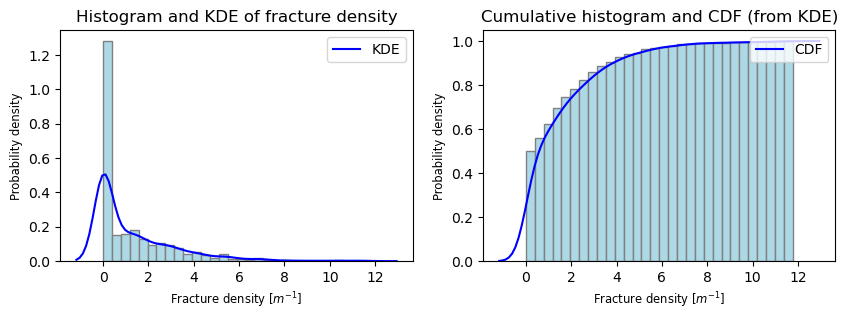

In [6]:
#Plot PDF and CDF
t = np.linspace(x_lim_left, x_lim_right, 100)
plt.subplots(1,2, figsize=(10,3))

# pdf
plt.subplot(1,2,1)
plt.hist(x, density=True, bins=30, color='lightblue', edgecolor='gray')
plt.plot(t, x_kde.evaluate(t), color='blue', label='KDE')

plt.xlabel('Fracture density [$m^{-1}$]',fontsize='small')
plt.ylabel('Probability density',fontsize='small')
plt.title('Histogram and KDE of fracture density')
plt.legend(loc=1)

# cdf
plt.subplot(1,2,2)
plt.hist(x, density=True, cumulative=True, bins=30, color='lightblue', edgecolor='gray')
plt.plot(t, x_cdf(t), color='blue', label='CDF')

plt.title('Cumulative histogram and CDF (from KDE)')
plt.xlabel('Fracture density [$m^{-1}$]',fontsize='small')
plt.ylabel('Probability density',fontsize='small')
plt.legend(loc=1)

plt.show()

### Resample values from the modeled distribution

In [7]:
x_new = zfunc.pdf_model_rvs(x_cdf_inv, p_marg_left, x_marg_left, gpd_left, p_marg_right, x_marg_right, gpd_right, size=len(x))

### Define an image with the new value and export

In [8]:
# Define a new image, by replacing the initial values by the new ones respecting the order
x_rank_inv = np.argsort(x)
x_rank = np.argsort(x_rank_inv) # x_rand_inv[x_rank[i]] = i for all i

im_new = gn.img.copyImg(im)
im_new.val[0] = np.sort(x_new)[x_rank].reshape(im_new.val[0].shape)

# Where new image is lower than the original, subtitute for original
im_new.val[im_new.val<im.val] = im.val[im_new.val<im.val]

# Difference of the two images (new one - initial one)
im_diff = gn.img.copyImg(im)
im_diff= im_new.val - im.val

In [9]:
# Export new image
gn.img.writeImageGslib (im_new, 'data/naive.gslib')